In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [98]:
data = pd.read_csv('2024-10-27 Tam 2016 Data.csv')
input = pd.read_csv('Vaccine_Schemes.csv')

# Replace 'Mouse_1' with '1' in the 'Subject' column
data['Subject'] = data['Subject'].str.replace('Mouse_', '')
data['Time'] = data['Time'].str.replace('Day', '')

# Convert some column to numeric values
data['Subject'] = pd.to_numeric(data['Subject'], errors='coerce')
data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
data['Binding'] = pd.to_numeric(data['Binding'], errors='coerce')





In [99]:
#mouse1Data = data[(data['Subject'] == 1) & (data['Binding'] < 11)]

#rinData = rin[(rin['Vaccine Scheme'] == '1wk Exp-inc Prime/Bolus Boost Day 21')]

#plt.plot(input['1wk Exp-inc Prime/Bolus Boost Day 21'])

outputData = pd.DataFrame()
outputData['Days'] = np.arange(0, 57)


inputData = pd.DataFrame()
inputData['Days'] = input['Days']


# make a loop where at each iteration, i add one of the mice and there binding to 
# the output and the vaccine scheme to their input
alrLooked = set()
for x in data['Subject']:
    if(x not in alrLooked):      
        alrLooked.add(x)
        mouseXData = data[(data['Subject'] == x)]
        vaccine = mouseXData['Vaccine Scheme'].iloc[0] 


        binding_data = mouseXData[['Time', 'Binding']]

        if 0 not in binding_data['Time'].values:
            binding_data = pd.concat([binding_data, pd.DataFrame({'Time': [0], 'Binding': [0]})], ignore_index=True)
        else:
            binding_data.loc[binding_data['Time'] == 0, 'Binding'] = 0
        

        binding_data = binding_data.set_index('Time').reindex(np.arange(0, 57)).interpolate(method='linear').reset_index()
        binding_data = binding_data[binding_data['Time'] <= 56]


        outputData[x] = binding_data['Binding']
        inputData[x] = input[vaccine]

    inputData = inputData.copy() 
    outputData = outputData.copy()

inputData.to_csv('input_train.csv', index=False)
outputData.to_csv('output_train.csv', index=False)

In [130]:


rin = inputData.transpose()
rout = outputData.transpose()

x = np.array(rin)
y = np.array(rout)

accuracy = 0
while(accuracy < 0.55):
    # Split the data into training and testing sets
    indices = rin.index
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(x, y, indices, test_size=0.2)

    # Standardize the features (important for perceptron)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize the Perceptron

    linear_regression = LinearRegression()
    multi_output_regressor = MultiOutputRegressor(linear_regression)


    # Train the Perceptron
    multi_output_regressor.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = multi_output_regressor.predict(x_test)

    # Evaluate the model
    accuracy = multi_output_regressor.score(x_test, y_test)
print("Model accuracy:", accuracy)

Model accuracy: 0.6441681076574527


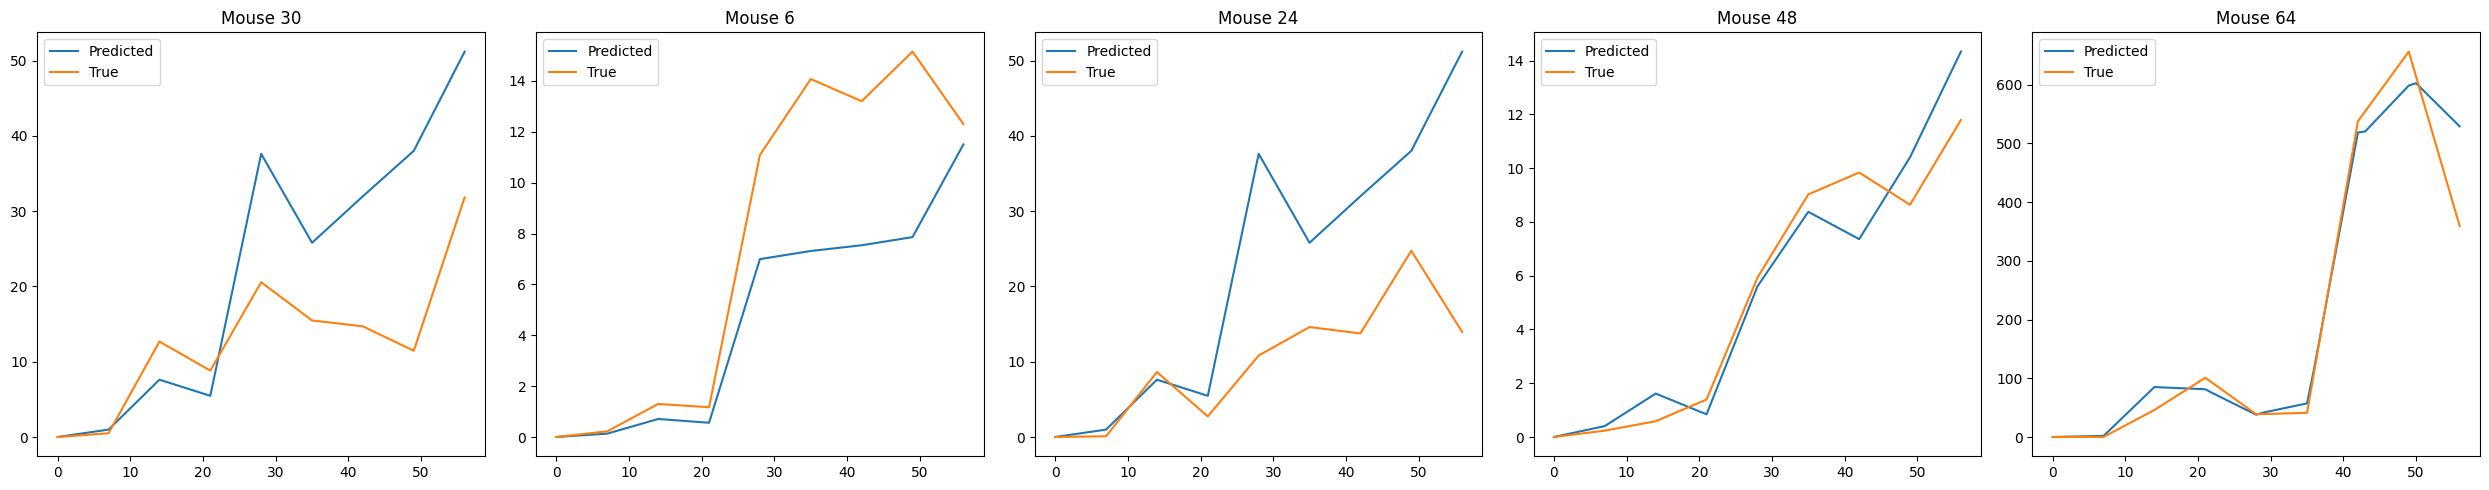

In [131]:
# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Plot the first 5 predictions and the corresponding true values
for i in range(5):
    mouse_label = test_idx[i]
    

    axes[i].plot(y_pred[i], label='Predicted')
    axes[i].plot(y_test[i], label='True')
    axes[i].set_title(f'Mouse {mouse_label}')
    axes[i].legend()

plt.tight_layout()
plt.show()